![](Rydiqule_Logo_Transparent_300.png)

# RF heterodyne with Doppler Example

This notebook demonstrates two-tone detection using a Rydberg sensor in the time domain with Doppler averaging.  An RF local oscillator (LO) and signal (sig) are imposed on the Rydberg sensor.  This is useful for RF phase detection, and can be used to linearize the detection, as shown below.  The main results of this example showing how different levels of Doppler averaging affect the beat signal size of the sensor. 

In [1]:
import datetime
from numba import vectorize, float64
##***LAST UPDATE***##
now = datetime.datetime.now()
print(now)

2023-10-11 10:52:41.251854


## Imports

In [2]:
import numpy as np
import rydiqule as rq
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

## Define the Sensors

In [4]:
rf_rabi = 100 #Mrad/s
red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*5}  #fields are stored as dictioniaries
blue_laser = {'states':(1,2), 'rabi_frequency':2*np.pi*7, 'detuning': 0}
LO_ss = {'states':(2,3), 'rabi_frequency':rf_rabi, 'detuning':0}

RydbergTargetState = [150, 2, 2.5, 0.5]  #states labeled n, l, j, m_j
RydbergExcitedState = [149, 3, 3.5, 0.5]

atom = "Rb85"
RbSensor_ss = rq.Cell(atom, *rq.D2_states(atom), RydbergTargetState, RydbergExcitedState,
                      gamma_transit=2*np.pi*1, cell_length = 0.01)
RbSensor_time = rq.Cell(atom, *rq.D2_states(atom), RydbergTargetState, RydbergExcitedState,
                      gamma_transit=2*np.pi*1, cell_length = 0.01)

In [5]:
state1 = RbSensor_time.states_list()[2]
state2 = RbSensor_time.states_list()[3]
print("1: ", state1)
print("2: ", state1)
dipoleMoment = RbSensor_time.atom.getDipoleMatrixElement(*state1,*state2, 0)

field = rf_rabi/rq.scale_dipole(dipoleMoment)

print("applied field, V/m:", field) #V/m
print("Rabi frequency, Mrad/s: ", field*rq.scale_dipole(dipoleMoment))

1:  [150, 2, 2.5, 0.5]
2:  [150, 2, 2.5, 0.5]
applied field, V/m: 0.08558532725336343
Rabi frequency, Mrad/s:  100.0


In [6]:
def sig_and_LO( delta, beta):
    def fun(t):
        return (1+beta*np.sin(delta*t))
    return fun

In [7]:
rf_freq = RbSensor_time.atom.getTransitionFrequency(*RydbergTargetState[:3],*RydbergExcitedState[:3])*1E-6
rf_freq #MHz


658.5872652398125

## Observe a heterodyne beat between the Signal and LO.

### Define the RF LO and signal

In [8]:
sampleNum = 200
endTime = 10 # microseconds
rf = sig_and_LO( 5, .1)

### Solve without Doppler averaging ###

Observe the beat between signal and LO fields.

In [9]:
red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*5, 'detuning':0}
blue_laser = {'states':(1,2), 'rabi_frequency':2*np.pi*7, 'detuning': 0}
rf = {'states':(2,3), "rabi_frequency": rf_rabi, 'detuning': 0, 'time_dependence': sig_and_LO( 2*np.pi, .05)}

RbSensor_time.add_couplings(blue_laser, red_laser, rf)


In [10]:
%%time
#Solve Without any doppler broadening

time_sol = rq.solve_time(RbSensor_time, endTime, sampleNum, atol=1e-6, rtol=1e-6)

CPU times: total: 172 ms
Wall time: 191 ms


In [11]:
transmission = time_sol.get_transmission_coef()

C:\Users\David\src\Rydiqule\src\rydiqule\sensor_solution.py:223: UserWarning: At least one solution has optical depth greater than 1. Integrated results are likely invalid.
  warnings.warn(('At least one solution has optical depth '


Text(0.5, 1.0, 'Doppler-Free Solution')

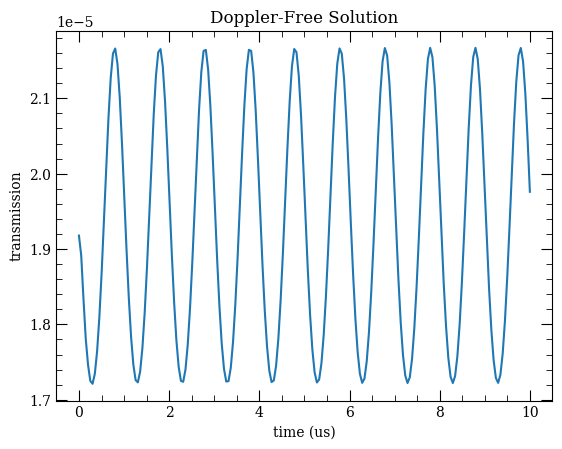

In [12]:
fig, ax = plt.subplots()
ax.plot(time_sol.t, transmission)
ax.set_xlabel("time (us)")
ax.set_ylabel('transmission')
ax.set_title("Doppler-Free Solution")

### Solve with Doppler averaging ###

Doppler averaged results require larger Rabi frequencies to observe similar sized signals.

In [13]:
red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*5, 'detuning':0, 'kvec': 500*(2*np.pi)*np.array([1,0,0])}
blue_laser = {'states':(1,2), 'rabi_frequency':2*np.pi*7, 'detuning': 0,'kvec': 308*(2*np.pi)*np.array([-1,0,0])}
#red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*1.0, 'detuning':0, 'kvec': 3*(2*np.pi)*np.array([1,0,0])}
#blue_laser = {'states':(1,2), 'rabi_frequency':2*np.pi*2.0, 'detuning': 0,'kvec': 1*(2*np.pi)*np.array([-1,0,0])}
rf = {'states':(2,3), "rabi_frequency":rf_rabi, 'detuning': 0, 'time_dependence': sig_and_LO( 2*np.pi, .05)}

RbSensor_time.add_couplings(blue_laser, red_laser, rf)

In [14]:
%%time
#Solve with a doppler peak calculated from physical system properties
sampleNum = 200
endTime = 10
time_sol_doppler = rq.solve_time(RbSensor_time, endTime, sampleNum, doppler=True, rtol = 1e-6, atol = 1e-6)

CPU times: total: 3min 11s
Wall time: 1min 38s


In [15]:
transmission_doppler = time_sol_doppler.get_transmission_coef()

Text(0.5, 1.0, 'Doppler Solution')

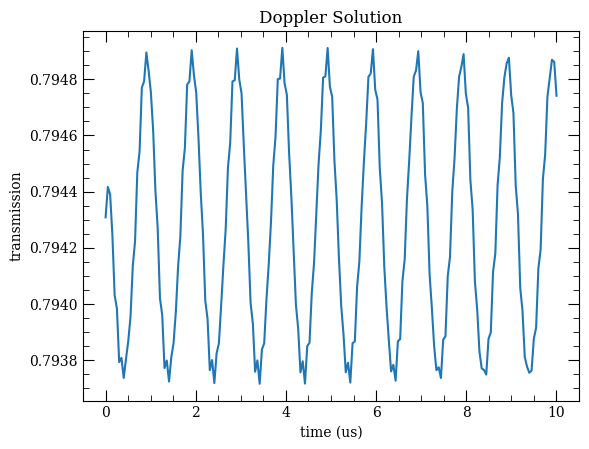

In [16]:
fig, ax = plt.subplots()
ax.plot(time_sol_doppler.t, transmission_doppler)
ax.set_xlabel("time (us)")
ax.set_ylabel('transmission')
ax.set_title("Doppler Solution")

### Solve with smaller Doppler Width ###

We can artificially reduce the amount of Doppler broadening. In this case, the default meshing of the velocity classes should be overridden to avoid excessive calculations.

In [17]:
red_laser = {'states':(0,1), 'rabi_frequency':2*np.pi*1.0, 'detuning':0, 'kvec': 1*(2*np.pi)*np.array([1,0,0])}
blue_laser = {'states':(1,2), 'rabi_frequency':2*np.pi*2.0, 'detuning': 0,'kvec': 0.6*(2*np.pi)*np.array([-1,0,0])}
rf = {'states':(2,3), "rabi_frequency":rf_rabi, 'detuning': 0, 'time_dependence': sig_and_LO( 2*np.pi, .05)}

RbSensor_time.add_couplings(blue_laser, red_laser, rf)

In [18]:
%%time
# Solve in the time domain with a 1MHz wide Doppler broadening
time_sol_doppler_narrow = rq.solve_time(RbSensor_time, endTime, sampleNum, 
                                        doppler=True, 
                                        doppler_mesh_method={'method':'uniform','width_doppler':2.5,'n_uniform':201},
                                        rtol = 1e-6, atol = 1e-6)

CPU times: total: 1.03 s
Wall time: 518 ms


In [19]:
transmission_doppler_narrow = time_sol_doppler_narrow.get_transmission_coef()

C:\Users\David\src\Rydiqule\src\rydiqule\sensor_solution.py:223: UserWarning: At least one solution has optical depth greater than 1. Integrated results are likely invalid.
  warnings.warn(('At least one solution has optical depth '


Text(0.5, 1.0, 'Small Doppler Solution')

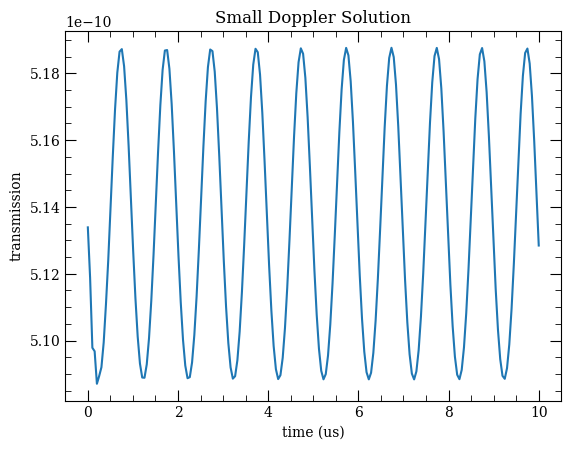

In [20]:
fig, ax = plt.subplots()
ax.plot(time_sol_doppler_narrow.t, transmission_doppler_narrow)
ax.set_xlabel("time (us)")
ax.set_ylabel('transmission')
ax.set_title("Small Doppler Solution")

### Compare the size of the beat signals

Here we ignore the starting transient, and normalize the beat signal. As the Doppler broadening is increased, the size of the beat is reduced (for the same optical depth).

In [21]:
def normalize_trace(trace,expand=1e2):
    ave = trace[100:].mean()
    return (trace - ave)/ave*expand

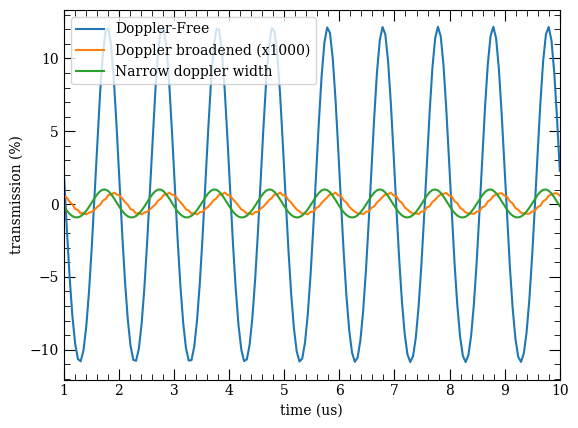

In [22]:
fig, ax = plt.subplots()

ax.plot(time_sol.t, normalize_trace(transmission), label='Doppler-Free')
ax.plot(time_sol_doppler.t, normalize_trace(transmission_doppler,1e3), label='Doppler broadened (x1000)')
ax.plot(time_sol_doppler_narrow.t, normalize_trace(transmission_doppler_narrow), label='Narrow doppler width')
ax.set_xlim((1,10))
ax.set_xlabel("time (us)")
ax.set_ylabel('transmission (%)')
ax.legend()

The authors recognize financial support from the US Army and Defense Advanced Research Projects Agency (DARPA). Rydiqule has been approved for unlimited public release by DEVCOM Army Research Laboratory and DARPA.  This software is released under the xx licence through the University of Maryland Quantum Technology Center.  The views, opinions and/or findings expressed here are those of the authors and should not be interpreted as representing the official views or policies of the Department of Defense or the U.S. Government.